In [1]:
import matplotlib.pyplot as plt
import numpy as np 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
torch .__version__

'1.5.0'

In [3]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
batch_size = 128
epochs = 5
learning_rate = 1e-3

In [5]:
# prepare dataset and transformation to model
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
    root = "~/torch_datasets", train= True, transform= transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [6]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape = 784).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)

        optimizer.zero_grad()

        outputs = model(batch_features)

        train_loss = criterion(outputs, batch_features)

        train_loss.backward()

        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(train_loader)

    print("epoch: {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch: 1/5, reconstruction loss = 0.06415353
epoch: 2/5, reconstruction loss = 0.04154361
epoch: 3/5, reconstruction loss = 0.03541106
epoch: 4/5, reconstruction loss = 0.02858840
epoch: 5/5, reconstruction loss = 0.02385408


In [13]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model(test_examples)
        break

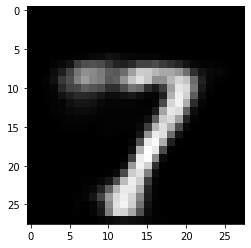

In [19]:
plt.imshow(reconstruction[0].reshape(28,28).cpu())
plt.show()

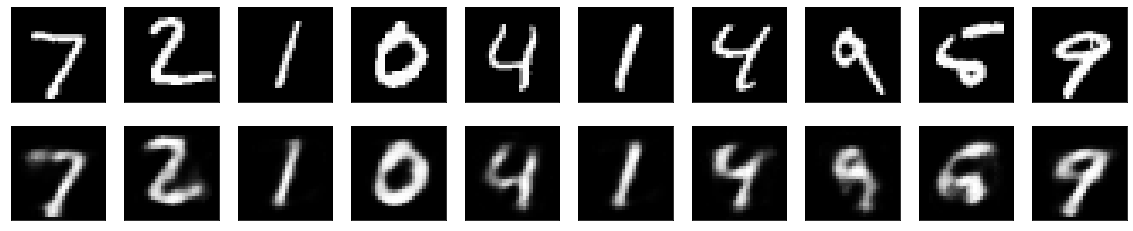

In [21]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20,4))

    for index in range(number):
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()